## 1. Introdução

### Perguntas que Tentaremos Responder

1. Como o custo do seguro de saúde varia com a idade, especialmente para fumantes?
2. Qual é a porcentagem de fumantes em relação ao número de filhos?
3. Como os custos de seguro de saúde variam por região e gênero?
4. Qual modelo de machine learning (Regressão Linear ou KNN) tem o melhor desempenho na previsão dos custos?

## 2. Carregando bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_palette("Accent")
sns.set_style("darkgrid")

## 3. Carregando dataset

In [3]:
df = pd.read_csv('./data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# Estatísticas descritivas
df.describe().round(2)

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


In [6]:
# Contagem de pessoas por região
df.groupby('region')['region'].count()

region
northeast    324
northwest    325
southeast    364
southwest    325
Name: region, dtype: int64

In [7]:
# Contagem de pessoas fumantes e não fumantes
df.groupby('smoker')['smoker'].count()

smoker
no     1064
yes     274
Name: smoker, dtype: int64

In [8]:
def lambda_region(x):
    if x == 'northeast':
        return 0
    if x == 'northwest':
        return 1 
    if x == 'southeast':
        return 2
    else:
        return 3

In [9]:
# Transformando 'smoker' e 'região' para valores númericos
df['smoker'] = df['smoker'].replace(['yes', 'no'], [1,0]) # 1 se o paciente for fumante e 0 se o paciente não for fumante
df['category_region'] = df['region'].apply(lambda_region)
df.head()

,age,sex,bmi,children,smoker,region,charges,category_region
0,19,female,27.900,0,1,southwest,16884.92400,3
1,18,male,33.770,1,0,southeast,1725.55230,2
2,28,male,33.000,3,0,southeast,4449.46200,2
3,33,male,22.705,0,0,northwest,21984.47061,1
4,32,male,28.880,0,0,northwest,3866.85520,1


In [10]:
# Matriz de correlação
df.corr()

,age,bmi,children,smoker,charges,category_region
age,1.000000,0.109272,0.042469,-0.025019,0.299008,0.002127
bmi,0.109272,1.000000,0.012759,0.003750,0.198341,0.157566
children,0.042469,0.012759,1.000000,0.007673,0.067998,0.016569
smoker,-0.025019,0.003750,0.007673,1.000000,0.787251,-0.002181
charges,0.299008,0.198341,0.067998,0.787251,1.000000,-0.006208
category_region,0.002127,0.157566,0.016569,-0.002181,-0.006208,1.000000


AxesSubplot(0.125,0.11;0.775x0.77)


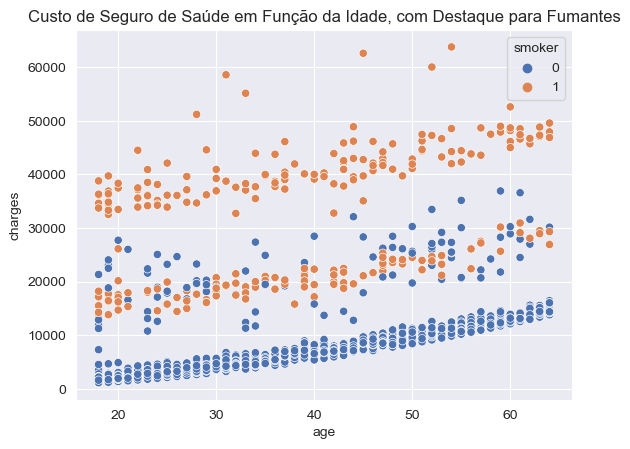

In [11]:
ax = sns.scatterplot(data=df, x="age", y="charges", hue='smoker', palette="deep")
ax.set(title='Custo de Seguro de Saúde em Função da Idade, com Destaque para Fumantes')
print(ax)

<AxesSubplot:title={'center':'Custo de Seguro de Saúde por Região e Gênero'}, xlabel='region', ylabel='charges'>

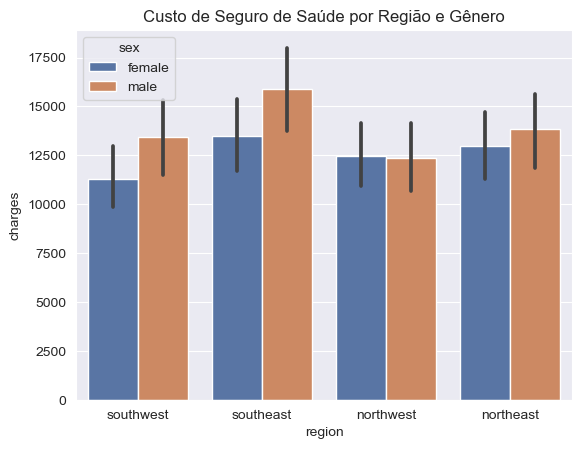

In [12]:
ax = sns.barplot(data=df, x="region", y="charges", hue='sex', palette="deep")
ax.set(title='Custo de Seguro de Saúde por Região e Gênero')
ax

In [13]:
# Agrupando por 'children' e 'smoker' e colentado o valor através de 'bmi'
df_children_smoker = df.groupby(['children', 'smoker']).count().reset_index()[['children', 'smoker', 'bmi']]

# Contagem total de pessoas por número de filhos.
df_children_smoker = df_children_smoker.merge(df.groupby('children').count()['age'].reset_index(), on='children')

# Renomeando a coluna 'age' para 'total_children'
df_children_smoker.rename(columns={'age': 'total_children'}, inplace=True)

# Calculando a porcentagem de fumantes por número de filhos
df_children_smoker['percentage'] = df_children_smoker['bmi'] / df_children_smoker['total_children']

# Filtrando apenas os dados para fumantes
#df_children_smoker.loc[df_children_smoker['smoker'] == 1]

<AxesSubplot:title={'center':'Porcentagem de Fumantes por Número de Filhos'}, xlabel='children', ylabel='percentage'>

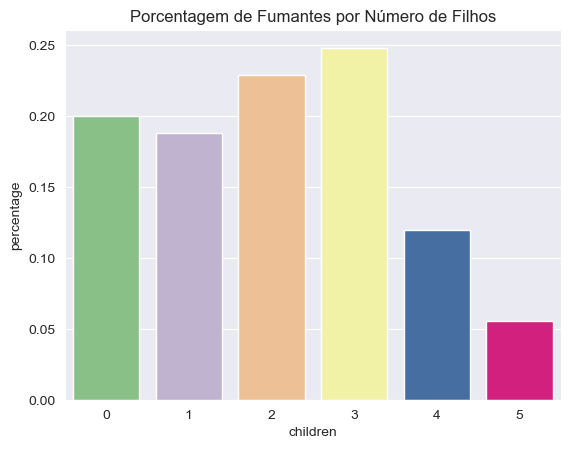

In [14]:
ax = sns.barplot(data=df_children_smoker.loc[df_children_smoker['smoker'] == 1], x='children', y='percentage')
ax.set(title='Porcentagem de Fumantes por Número de Filhos')
ax

In [15]:
df.drop(['region', 'category_region'], axis=1, inplace=True)

### Verificando outliers

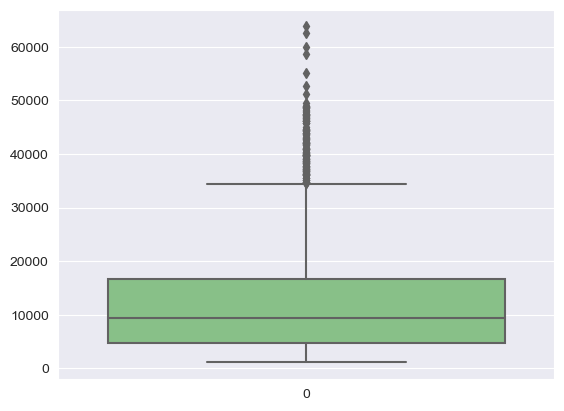

In [16]:
ax = sns.boxplot(data=df['charges'])

## 4. Distribuição de Frequências


Text(0.5, 1.0, 'Distribuição de Frequencia')

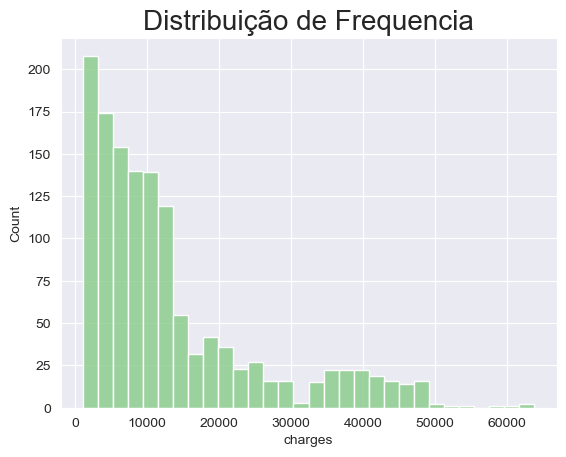

In [17]:
ax = sns.histplot(data = df['charges'])
ax.set_title("Distribuição de Frequencia", fontsize=20)

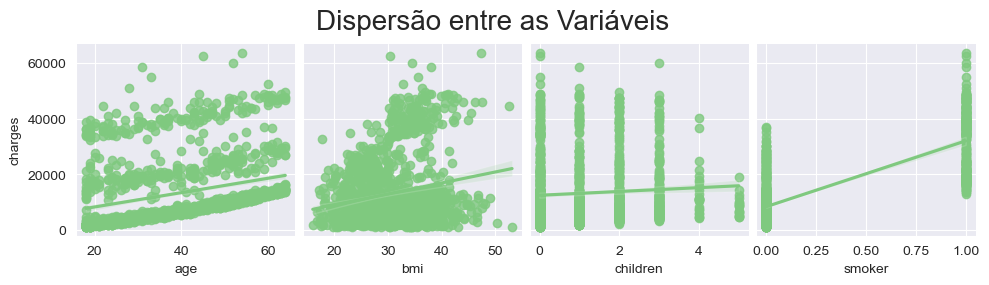

In [18]:
# Dispersão Entre as Variáveis
ax = sns.pairplot(data=df, y_vars='charges', x_vars=['age', 'bmi', 'children', 'smoker'],kind='reg' )
ax.fig.suptitle('Dispersão entre as Variáveis', fontsize=20, y=1.1)
ax

## 5. Transformando os Dados

In [19]:
# Aplicando a transformação logarítmica aos dados do dataset
df['log_age'] = np.log(df['age'])
df['log_bmi'] = np.log(df['bmi'])
df['log_charges'] = np.log(df['charges'])
df['log_smoker'] =  np.log(df['smoker'] + 1)
df['log_children'] =  np.log(df['children'] + 1)
df

,age,sex,bmi,children,smoker,charges,log_age,log_bmi,log_charges,log_smoker,log_children
0,19,female,27.900,0,1,16884.92400,2.944439,3.328627,9.734176,0.693147,0.000000
1,18,male,33.770,1,0,1725.55230,2.890372,3.519573,7.453302,0.000000,0.693147
2,28,male,33.000,3,0,4449.46200,3.332205,3.496508,8.400538,0.000000,1.386294
3,33,male,22.705,0,0,21984.47061,3.496508,3.122585,9.998092,0.000000,0.000000
4,32,male,28.880,0,0,3866.85520,3.465736,3.363149,8.260197,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,0,10600.54830,3.912023,3.433019,9.268661,0.000000,1.386294
1334,18,female,31.920,0,0,2205.98080,2.890372,3.463233,7.698927,0.000000,0.000000
1335,18,female,36.850,0,0,1629.83350,2.890372,3.606856,7.396233,0.000000,0.000000
1336,21,female,25.800,0,0,2007.94500,3.044522,3.250374,7.604867,0.000000,0.000000


Text(0.5, 1.0, 'Distribuição de Frequencia (Log)')

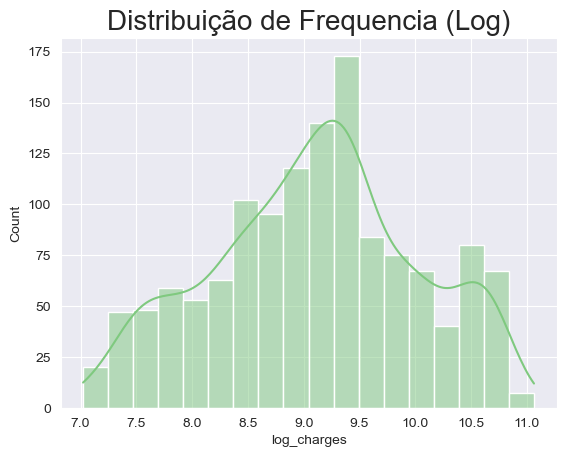

In [20]:
# Distribuição de frequências da variável dependente transformada (y)
ax = sns.histplot(data=df['log_charges'], kde=True)
ax.set_title("Distribuição de Frequencia (Log)", fontsize=20)

In [21]:
df.corr()

,age,bmi,children,smoker,charges,log_age,log_bmi,log_charges,log_smoker,log_children
age,1.000000,0.109272,0.042469,-0.025019,0.299008,0.986326,0.116146,0.527834,-0.025019,0.048406
bmi,0.109272,1.000000,0.012759,0.003750,0.198341,0.102185,0.991023,0.132669,0.003750,0.016178
children,0.042469,0.012759,1.000000,0.007673,0.067998,0.090605,0.013058,0.161336,0.007673,0.972128
smoker,-0.025019,0.003750,0.007673,1.000000,0.787251,-0.022613,0.000366,0.665506,1.000000,0.013245
charges,0.299008,0.198341,0.067998,0.787251,1.000000,0.289967,0.199266,0.892964,0.787251,0.075976
log_age,0.986326,0.102185,0.090605,-0.022613,0.289967,1.000000,0.109435,0.535062,-0.022613,0.103153
log_bmi,0.116146,0.991023,0.013058,0.000366,0.199266,0.109435,1.000000,0.137924,0.000366,0.015812
log_charges,0.527834,0.132669,0.161336,0.665506,0.892964,0.535062,0.137924,1.000000,0.665506,0.171784
log_smoker,-0.025019,0.003750,0.007673,1.000000,0.787251,-0.022613,0.000366,0.665506,1.000000,0.013245
log_children,0.048406,0.016178,0.972128,0.013245,0.075976,0.103153,0.015812,0.171784,0.013245,1.000000


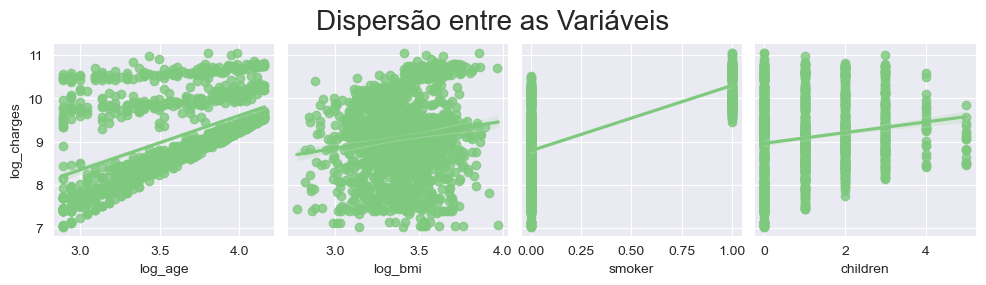

In [22]:
ax = sns.pairplot(data=df, y_vars='log_charges', x_vars=['log_age', 'log_bmi', 'smoker', 'children'],kind='reg')
ax.fig.suptitle('Dispersão entre as Variáveis', fontsize=20, y=1.1)
ax

## 6 Modelos

## 6.1 Regressão Linear

In [23]:
# Variável dependente
y = df['log_charges']

In [24]:
# Variáveis independente
X = df[['log_age', 'log_bmi', 'log_children', 'log_smoker']]

In [25]:
# Criando os datasets de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2811)

In [26]:
ml1 = LinearRegression()

In [27]:
ml1.fit(X_train, y_train)

LinearRegression()

In [28]:
score_regression = ml1.score(X_test, y_test)

## 6.2 k-vizinhos mais próximos (KNN)

In [29]:
neigh = KNeighborsRegressor(n_neighbors=3)

In [30]:
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [31]:
score_neigh = neigh.score(X_test, y_test)

In [32]:
# Comparação dos modelos
model_scores = pd.DataFrame(data=[score_regression * 100, score_neigh * 100], columns=['Modelos'], index=['Linear Regression', 'KNeighborsRegressor'])
model_scores

,Modelos
Linear Regression,78.280760
KNeighborsRegressor,80.972424


## 7 Salvando o modelo estimado

In [33]:
output = open('pickle_modelo', 'wb')
pickle.dump(neigh, output)
output.close()